In [828]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import re
import time
from BusinessHours import BusinessHours as bh
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Imputer
from sklearn.metrics import make_scorer 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn import metrics

In [829]:
df = pd.read_csv('train_aWnotuB.csv')
df_test = pd.read_csv('test_BdBKkAj.csv')

In [830]:
#df_test.groupby('Junction').count()
#df.Vehicles.
#df.describe()

In [831]:
#df = df_train[df.columns.difference(['ID'])]

In [832]:
def add_date_features(df):
    df['date'] = pd.to_datetime(df['DateTime'])
    dti = pd.DatetimeIndex(df['date'])
    holidays = calendar().holidays(start=dti.min(), end=dti.max())

    df['year'] = dti.year
    df['quarter'] = dti.quarter
    df['month'] = dti.month
    df['week'] = dti.week
    df['weekofyear'] = dti.weekofyear
    df['day'] = dti.day
    df['dayofweek'] = dti.dayofweek
    df['dayofyear'] = dti.dayofyear
    df['hour'] = dti.hour
    df['minofday'] = dti.hour*60+dti.minute
    df['bhour'] = df['hour']
    df['bhour'] = df['bhour'].replace(range(1,8), 0).replace(range(8,19), 1).replace(range(19,24), 0)
    df['holiday'] = dti.isin(holidays)
    df['holiday'] = df['holiday'].map({False:0, True:1})
    
add_date_features(df)
add_date_features(df_test)

# df['year'], df['month'], df['week'], df['day'], df['dayofweek'], df['hour'], df['minofday'] = \
# df['date'].dt.year, df['date'].dt.month, df['date'].dt.week, df['date'].dt.day, df['date'].dt.dayofweek, df['date'].dt.hour, df['date'].dt.hour*60+df['date'].dt.minute

In [833]:
dti = pd.DatetimeIndex(df['date'])
dti.dayofweek

Int64Index([6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='date', length=48120)

In [834]:
#df.date = df.DateTime.apply(lambda x: time.mktime(pd.Timestamp(x).to_datetime().timetuple()))

In [835]:
# from tsfresh import extract_relevant_features
# extracted_features = extract_relevant_features(df, df.Vehicles, column_sort="DateTime", column_id="Junction", column_value="Vehicles", n_jobs=4)

In [836]:
#vehicles

In [837]:
# #temps = DataFrame(df.Vehicles)
# # dataframe = concat([temps.shift(1), temps], axis=1)
# # dataframe.columns = ['t-1', 't+1']
# def lag(df):
#     vehicles = df.Vehicles
#     dataframe = pd.concat([vehicles.shift(3), vehicles.shift(2), vehicles.shift(1), vehicles], axis=1)
#     dataframe.columns = ['t-3', 't-2', 't-1', 't+1']
#     print(dataframe.head(5))
# vehicles = df.groupby('Junction').apply(lag)

In [838]:
def window_features(df):
    width = 3
    v = df['Vehicles']
    shifted = v.shift(width - 1)
    window = shifted.rolling(window=width)
    exp = v.expanding()
    dataframe = pd.concat([window.min(), window.mean(), window.max(), exp.min(), exp.mean(), exp.max(), v], axis=1)
    dataframe.columns = ['s_min', 's_mean', 's_max', 'e_min', 'e_mean', 'e_max', 's_t+1']
    #print(dataframe.head(5))
    return dataframe
#window(df)

def merge_features(df, vehicles):
    df['s_min'] = vehicles['s_min']
    df['s_mean'] = vehicles['s_mean']
    df['s_max'] = vehicles['s_max']
    df['e_min'] = vehicles['e_min']
    df['e_mean'] = vehicles['e_mean']
    df['e_max'] = vehicles['e_max']

merge_features(df, df.groupby('Junction').apply(window_features))
#merge_features(df_test, df_test.groupby('Junction').apply(window_features))

#vehicles.head()

In [839]:
#df_test.ix[[len(df_test)-2]]

# out = df_test.groupby('Junction').nth(1).reset_index()
# for j in range(2, 5):  
#     out = out.append(df_test.groupby('Junction').nth(j).reset_index())

In [840]:
# df = df.append(out)

In [841]:
#n = len(df)
# inn = df.groupby('Junction').nth(-1).reset_index()
# for j in range(2, 5):  
#     inn = out.append(df_test.groupby('Junction').nth(-j).reset_index())

In [842]:
#df.groupby('Junction').size()
#df.groupby('Junction').nth(-1).reset_index()
#inn


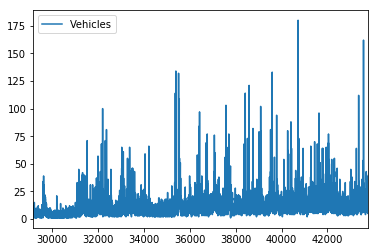

In [843]:
df[df['Junction']==3][['date', 'Vehicles']].plot()

(array([  1.13190000e+04,   2.87900000e+03,   2.79000000e+02,
          6.30000000e+01,   2.60000000e+01,   1.10000000e+01,
          9.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   18.9,   36.8,   54.7,   72.6,   90.5,  108.4,  126.3,
         144.2,  162.1,  180. ]),
 <a list of 10 Patch objects>)

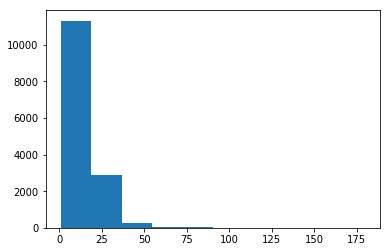

In [844]:
plt.hist(df[df['Junction']==3]['Vehicles'])

In [845]:
# corrmat = df.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

In [846]:

# sns.set()
# sns.pairplot(df)
# plt.show();

In [847]:
X_test_Id = df_test[['ID']]
df.drop(['ID', 'DateTime', 'date'], inplace=True, axis=1)
df_test.drop(['ID', 'DateTime', 'date'], inplace=True, axis=1)
y_train = df.Vehicles
X_train = df.drop('Vehicles', axis=1)

# X_val = val.drop('Vehicles', axis=1)
# y_val = val.Vehicles.values
X_test = df_test
num_cols = list(X_train.columns.get_values())
num_cols.remove('Junction')
cat_cols = ['Junction']

In [848]:
#df.Vehicles

### Check missing values

In [849]:
pd.isnull(train).sum()

dayofweek     0
year          0
bhour         0
day           0
e_min         0
holiday       0
e_mean        0
minofday      0
e_max         0
weekofyear    0
s_mean        0
Junction=1    0
Junction=2    0
Junction=3    0
Junction=4    0
Vehicles      0
dtype: int64

In [850]:
from collections import defaultdict
d = defaultdict(list)
X_train[cat_cols].apply(lambda x: d[x.name].append(x.value_counts().idxmax())) 
ohe = OneHotEncoder().fit(X_train[cat_cols])
#cols = [cat_cols[i] + '=' + str(d[cat_cols[i]].classes_[j]) for i in range(0,len(cat_cols)) for j in range(0,ohe.n_values_[i])]
cols = [cat_cols[i] + '=' + str(j) for i in range(0,len(cat_cols)) for j in range(1,ohe.n_values_[i])]

X_train_cat = pd.DataFrame(ohe.transform(X_train[cat_cols]).toarray(), columns=cols)
#X_val_cat = pd.DataFrame(ohe.transform(X_val[cat_cols]).toarray(), columns=cols)
X_test_cat = pd.DataFrame(ohe.transform(X_test[cat_cols]).toarray(), columns=cols)

# from sklearn.feature_extraction import DictVectorizer
# vec = DictVectorizer().fit(X_train[cat_cols].to_dict('records'))
# X_train_cat = pd.DataFrame(vec.transform(X_train[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())
# X_val_cat = pd.DataFrame(vec.transform(X_val[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())
# X_test_cat = pd.DataFrame(vec.transform(X_test[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())

In [851]:
# imp_num = Imputer(missing_values='NaN', strategy='mean', axis=0).fit(X_train[num_cols])
# X_train[num_cols] = imp_num.transform(X_train[num_cols])
# X_val[num_cols] = imp_num.transform(X_val[num_cols])
# X_test[num_cols] = imp_num.transform(X_test[num_cols])
#X_train.dropna(inplace=True)
#X_val.dropna(inplace=True)
dropix = pd.isnull(X_train).any(1).nonzero()[0]
X_train.drop(dropix, inplace=True)
y_train.drop(dropix, inplace=True)

In [852]:
X_train[num_cols].columns

Index(['year', 'quarter', 'month', 'week', 'weekofyear', 'day', 'dayofweek',
       'dayofyear', 'hour', 'minofday', 'bhour', 'holiday', 's_min', 's_mean',
       's_max', 'e_min', 'e_mean', 'e_max'],
      dtype='object')

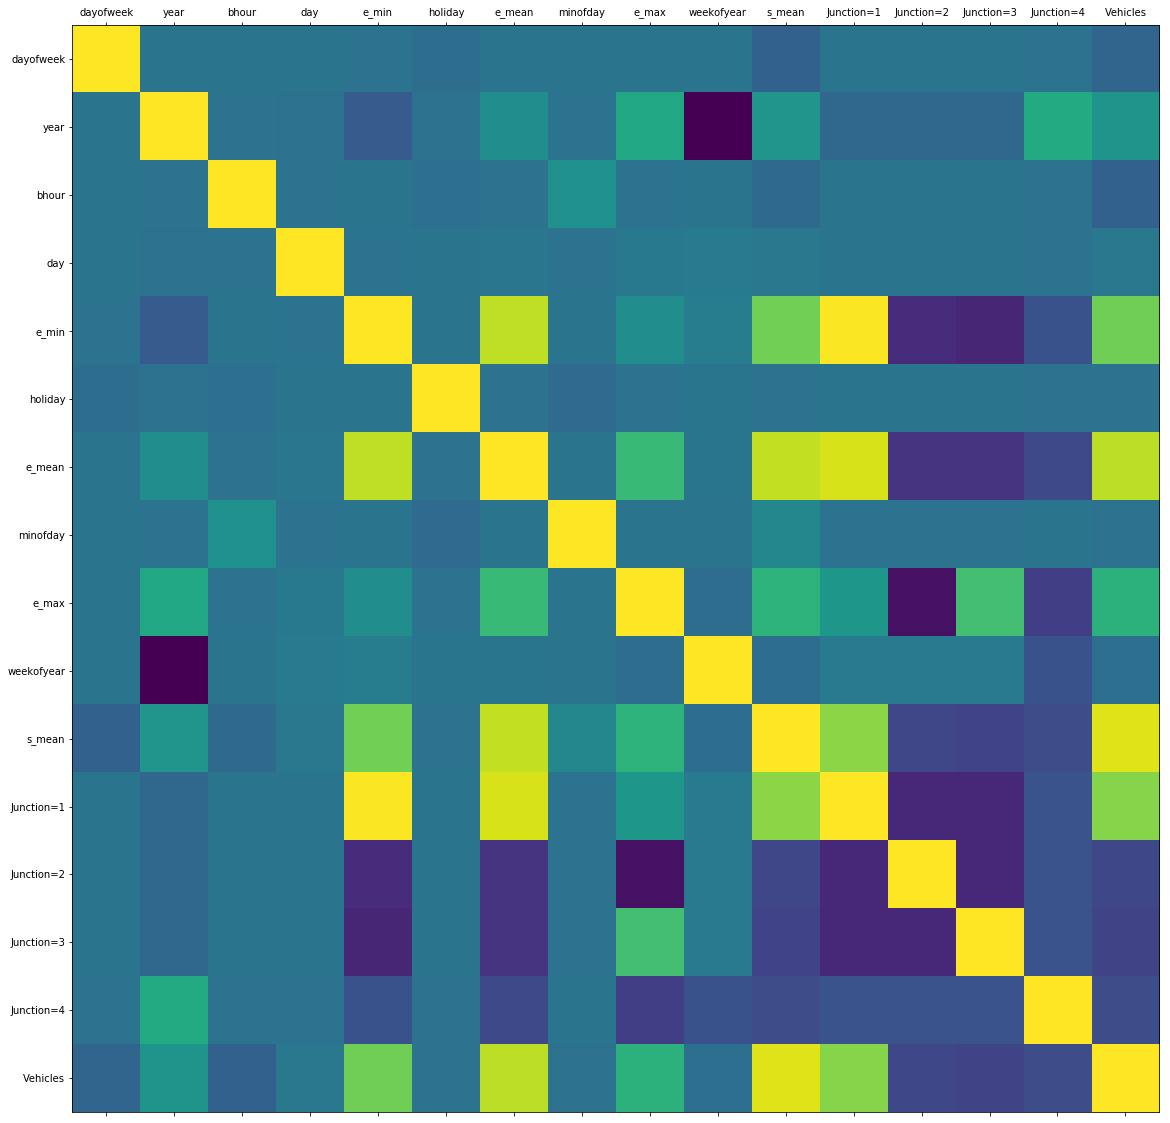

[('e_min', 'Junction=1'), ('e_mean', 'Junction=1'), ('s_mean', 'Vehicles')]

In [853]:
corr = X_train_full.corr()
#print(corr)
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);
plt.show()
corr_matrix = corr.abs()
high_corr_var=np.where(corr_matrix>0.9)
[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [854]:
# X_train = X_train.drop(['quarter', 'month', 'week', 'dayofyear', 'hour', 's_min', 's_max'], axis=1)
# X_test = X_test.drop(['quarter', 'month', 'week', 'dayofyear', 'hour'], axis=1)

In [858]:
#num_cols = list(set(num_cols)-set(['quarter', 'month', 'week', 'dayofyear', 'hour', 's_min', 's_max']))

from sklearn.decomposition import PCA, KernelPCA
# kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10).fit_transform(X_train)
# X_back = kpca.inverse_transform(X_kpca)
PCA().fit_transform(X_train).shape


(48104, 19)

In [859]:
X_train.shape

(48104, 19)

In [814]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[num_cols])
X_train_num = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols)
#X_val_num = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
#X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

In [815]:
X_train.shape

(48104, 12)

In [816]:
X_train = X_train_num.join(X_train_cat)
X_test = X_test_num.join(X_test_cat)
#X_val = X_val_num.join(X_val_cat)
X_train['Vehicles'] = y_train
X_train_full = X_train

In [817]:
X_train_full.dropna(inplace=True)
train, val = np.split(X_train_full.sample(frac=1), [int(.99*len(df))])
X_train = train.drop('Vehicles', axis=1)
y_train = train.Vehicles.values
X_val = val.drop('Vehicles', axis=1)
y_val = val.Vehicles.values

In [818]:
# model = LinearRegression().fit(X_train, y_train)
# model = XGBRegressor().fit(X_train, y_train)

In [819]:
# from sklearn.ensemble import BaggingRegressor
# #lr = LinearRegression()
# svr_lin = SVR(kernel='linear')
# ridge = Ridge(random_state=1)
# svr_rbf = SVR(kernel='rbf')
# bag = BaggingRegressor()
params = {'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}
xgb = XGBRegressor(subsample=0.7, n_estimators=500, min_child_weight=4, max_depth=7, learning_rate=0.07, colsample_bytree=0.7)


# from mlxtend.regressor import StackingRegressor
# model = StackingRegressor(regressors=[svr_lin, lr, ridge], 
#                            meta_regressor=svr_rbf)

parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

# model = GridSearchCV(xgb,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)


model = xgb
model.fit(X_train, y_train)
model.best_score_
model.best_params_

AttributeError: 'XGBRegressor' object has no attribute 'best_score_'

In [820]:
X_val = X_val.reset_index(drop=True)
y_pred = model.predict(X_val)
metrics.mean_squared_error(y_val, y_pred)
#X_valm = X_val.as_matrix()

10.271409253832722

In [ ]:
#X_train_full.columns
#X_train_full = X_train_full.reset_index(drop=True)
#X_train_full[X_train_full['Junction=%d'%1]==1].tail(1)['Vehicles'].values[0]
#X_train_full
X_train.columns

In [821]:
X_test['Vehicles'] = np.zeros(X_test.shape[0])

In [822]:
#ntrain = X_train_full.shape[0]
ntest = X_test.shape[0]
#X_train_fulls = X_train_full.append(X_test, ignore_index=True).reset_index(drop=True)
X_train_full.dropna(inplace=True)
X_train_full = X_train_full.reset_index(drop=True)
#print(X_train_full.ix[0])

In [ ]:
X_train_full.columns

In [825]:
#X_test = X_test

#def window_predict():
res = pd.DataFrame()
lst = list()
#for i in range(ntrain, ntrain+ntest):
for i in range(ntest):
    #dd = pd.DataFrame(X_train_fulls[i]).T
    dd = pd.DataFrame(X_test.ix[i]).T
    dd.columns = X_test.columns
    #dd.fillna(method='ffill')
    J = 0
    for j in range(1,5):
        if dd['Junction=%d'%j].values[0]==1:
            J = j
            break
    dd.ix[0, 'Vehicles'] = X_train_full[X_train_full['Junction=%d'%J]==1].tail(1)['Vehicles'].values[0]
    #dd = pd.DataFrame(dd)
    #print(dd)
    ddd = X_train_full.append(dd, ignore_index=True)
    #merge_features(dd, window_features(dd))
    #print(ddd[ddd['Junction=%d'%J]==1])
#     print(pd.isnull(ddd).any(1).nonzero()[0])
#     print(ddd.shape)
    #print(ddd[ddd['Junction=%d'%J]==1].shape)
    #print(window_features(ddd[ddd['Junction=%d'%J]==1]))
    merge_features(ddd, window_features(ddd[ddd['Junction=%d'%J]==1]))
    ddd.dropna(inplace=True)
    ddd = ddd[ddd.columns.difference(['quarter', 'month', 'week', 'dayofyear', 'hour', 's_min', 's_max'])]
    cat_cols = list(set(ddd.columns.tolist())-set(num_cols))
    
    ddd = pd.DataFrame(scaler.transform(ddd[num_cols]), columns=num_cols).join(ddd[cat_cols].sort_index(axis=1))
    #dd.ix[0, 'Vehicles'] =
    dd = ddd.tail(1).drop('Vehicles', axis=1)
    lst.append(model.predict(dd))
    
# df_test = pd.read_csv('test_BdBKkAj.csv')
# df_test
# model.predict(X_val)
#pd.DataFrame(X_val.ix[0]).T


#df.groupby('Junction').apply(window_predict)

/home/smrutiranjans/miniconda3/envs/ai/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [ ]:
pd.Series([l[0] for l in lst]).values.round().astype('int')

In [826]:
#X_test_Id['Vehicles'] = model.predict(X_test).round().astype('int')
X_test_Id['Vehicles'] = pd.Series([l[0] for l in lst]).values.round().astype('int')
X_test_Id.to_csv('remove_corr_full.csv', index=False)

/home/smrutiranjans/miniconda3/envs/ai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
